In [1]:
from collections import OrderedDict
import swmmAPImini as sm
import mbc

SWMM Input File

In [2]:
swmmINP = 'NoWestside_withISDs_RainEvents.inp'
simNotes = ['setpoint 5 lower weight on forebay, 900 sec time step']

Save Your Shit

In [3]:
pickleOut = 'orifice_qaqc_7.p'
metaCSV = 'CC_FV_FREUD_meta.csv'

Read Control Points from CSV files
CSV files are the files that should be changed

In [4]:
cF = 'input_files/ControlPoints_Init_CC_FV_FREUD.csv'
uF = 'input_files/Upstream_Init_CC_FV_FREUD.csv'
dF = 'input_files/Downstream_Init_CC_FV_FREUD.csv'
pF = 'input_files/PerformancePoints_Init.csv' # Elements of interest in SWMM to analyze performance

controlDict = sm.return_inputs(cF,'control')
upstreamDict = sm.return_inputs(uF,'upstream')
downstreamDict = sm.return_inputs(dF,'downstream')
performanceDict = sm.return_inputs(pF,'performance')
dsKeys = list(downstreamDict.keys())

In [5]:
# With or without control?
control = True

Process swmm elements into a dictionary. Change txt element files within swmmAPImini.py

In [6]:
conduits,nodes,storages,subcatchments,outfalls,orifices,pumps = sm.make_element_dictionaries()

Get depth and flow information from swmm element dictionaries

In [7]:
sm.get_depth(upstreamDict,conduits,storages)
sm.get_depth(downstreamDict,conduits,storages)
sm.get_q_full_and_other(downstreamDict,conduits,storages)
sm.orifice_xsect_grab(controlDict,orifices)
sm.pump_curve_grab(controlDict,pumps)

timestep = sm.get_timestep(swmmINP)

sm.performance_elements(performanceDict,conduits,nodes,storages,subcatchments,outfalls,orifices)
dsKeys = list(downstreamDict.keys())

In [8]:
downstreamDict

OrderedDict([('2909',
              OrderedDict([('type', 'storage'),
                           ('measure', 'depth'),
                           ('epsilon', 10),
                           ('gamma', 0),
                           ('max_depth', 34.0),
                           ('set_point', 5),
                           ('set_derivative', 0),
                           ('location', 'CC RTB'),
                           ('ts_flow', []),
                           ('ts_depth', []),
                           ('total_storage', 6529421.199999999)]))])

Variable Management

In [9]:
try:
    del conduits
    del nodes
    del storages
    del subcatchments
    del outfalls
except:
    pass

In [10]:
downstreamDict[dsKeys[0]]['max_flow'] = 1.0

In [11]:
%%time
if control:
    price, PDemand = mbc.run_control_sim(controlDict,upstreamDict,downstreamDict,dsKeys,swmmINP,performanceDict,timestep)
else:
    mbc.run_no_control_sim(controlDict,upstreamDict,downstreamDict,dsKeys,swmmINP,performanceDict)

running simulation...
done ...
Wall time: 50min 51s


# Save That Shit

In [12]:
saveDict = {
    'controlDict':controlDict,
    'upstreamDict':upstreamDict,
    'downstreamDict':downstreamDict,
    'metaCSV':metaCSV,
    'pickleOut':pickleOut,
    'notes':simNotes,
    'file':swmmINP,
    'control':str(control),
    'performanceDict':performanceDict
}

try:
    saveDict['price'] = price
    saveDict['PDemand'] = PDemand
except:
    pass

mbc.save_that_shit(saveDict)

# Visualize That Shit

In [13]:
import pickle
%matplotlib inline
f_nocontrol = 'orifice_qaqc_7.p'
f_control = 'orifice_qaqc_6.p'
figname = 'OrificeQaQc.png'

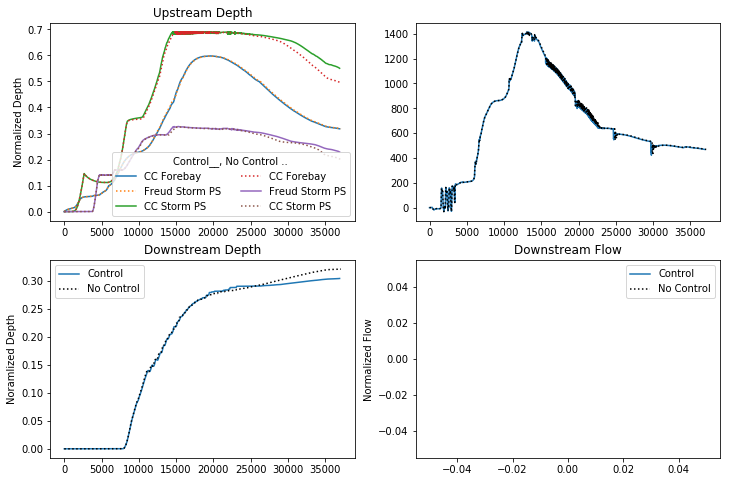

In [14]:
mbc.viz_shit(f_nocontrol,f_control,figname)

In [21]:
controlDict['ORIFICE33@17312-17313'].keys()

odict_keys(['type', 'USasset', 'action', 'actionTS', 'q_goal', 'from_node', 'to_node', 'offset', 'Cd', 'gated', 'close_time', 'shape', 'geom1', 'geom2', 'geom3', 'geom4'])

In [13]:
import matplotlib.pyplot as plt

In [16]:
with open('orifice_qaqc_1.p','rb') as f:
    qa1 = pickle.load(f)
    
performanceDict = qa1['performanceDict']
performanceDict.keys()

odict_keys(['1002', '200', '100', '1686', '2908'])

OrderedDict([('type', 'node'), ('ts_flow', []), ('ts_depth', [])])

In [12]:
# performanceDict['2908']

OrderedDict([('type', 'outfall'),
             ('ts_flow',
              [0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
 

In [20]:
# def mbc(ustream, dstream, setpts, uparam, dparam, n_tanks, action):
#     p = (sum(uparam*ustream) + sum(dparam*(dstream-setpts)))/(1 + n_tanks)
#     PD = np.zeros(n_tanks)
#     for i in range(0,n_tanks):
#         PD[i] = max(-p + uparam[i]*ustream[i],0)
#     PS = sum(PD)
#     for i in range(0,n_tanks):
#         if PS == 0:
#             Qi = 0
#         else:
#             Qi = PD[i]/PS*setpts[0] # setpts[0] assumed to be downstream flow setpoint
# #             Qi = sum(PD[0:i+1])/PS*setpts[0] # setpts[0] assumed to be downstream flow setpoint
#         if ustream[i] == 0:
#             action[i] = 0.5
#         else:
#             h2i = Qi/(1.0*1*np.sqrt(2*9.81*ustream[i]))
# #             h2i = Qi/(0.61*1*np.sqrt(2*9.81*ustream[i]))
#             action[i] = max(min(h2i/2,1.0),0.0)
# #         if ustream[i] > 0.95:
# #             action[i] = 1.0

#     return p, PD, PS, action

In [22]:
# with Simulation('FirstHamilton_pruned_noUP.inp') as sim:
#     start = sim.start_time
#     end = sim.end_time
#     freq = '12s'
#     timesteps = pd.date_range(start,end,freq=freq)
#     price = []
#     PDemand = []
    
#     nodes = Nodes(sim)
#     links = Links(sim)
    
#     for point in controlDict:
#         controlDict[point]['pyswmmVar'] = links[point]
#     for point in upstreamDict:
#         upstreamDict[point]['pyswmmVar'] = links[point]
#     for point in downstreamDict:
#         downstreamDict[point]['pyswmmVar'] = links[point]
        
#     # These currently don't change per timestep. That is a possibility though
#     setpts = np.array([downstreamDict[dsKeys[0]]['set_point'],downstreamDict[dsKeys[0]]['set_derivative']])
#     uparam = np.array([1.0,0.1,0.1,0.1,0.1]) #for now make it a scalar... can diversify if needed once we want to prioritize upstream links above others
#     dparam = [downstreamDict[dsKeys[0]]['epsilon'],downstreamDict[dsKeys[0]]['gamma']]
#     n_tanks = len(upstreamDict)
        
#     print('entering simulation')
#     for step in sim:
#         for point in upstreamDict:
#             upstreamDict[point]['ts'].append(upstreamDict[point]['pyswmmVar'].depth / upstreamDict[point]['max_depth'])
#         for point,i in zip(downstreamDict,range(0,len(downstreamDict))):
#             downstreamDict[point]['ts_flow'].append(downstreamDict[point]['pyswmmVar'].flow / downstreamDict[point]['max_flow'])
#             downstreamDict[point]['ts_depth'].append(downstreamDict[point]['pyswmmVar'].depth / downstreamDict[point]['max_depth'])
        
#         ustream = np.array([upstreamDict[i]['ts'][-1] for i in upstreamDict])
#         try:
#             dstream = np.array([downstreamDict[dsKeys[0]]['ts_flow'][-1],downstreamDict[dsKeys[0]]['ts_flow'][-1]-downstreamDict[dsKeys[0]]['ts_flow'][-2]])
#         except:
#             dstream = np.array([downstreamDict[dsKeys[0]]['ts_flow'][-1],0])
        
#         n_tanks = len(upstreamDict)
#         action = [controlDict[i]['action'] for i in controlDict]
        
#         p, PD, PS, action = mbc(ustream, dstream, setpts, uparam, dparam, n_tanks, action)
        
#         PDemand.append(PD)
#         price.append(p)
        
#         for point,i in zip(controlDict,range(0,len(action))):
#             controlDict[point]['pyswmmVar'].target_setting = action[i]
#             controlDict[point]['actionTS'].append(action[i])
            
# print('done ...')

done ...
